# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

This notebook is designed to help you build your first machine learning model and start competing the tournament.

In this notebook we will
1. Download and explore the Numerai dataset
2. Train and evaluate your first machine learning model
3. Deploy your model to start making live submissions

## 1. Dataset  



In [10]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
import json 
import pandas as pd
from catboost import CatBoostRegressor


napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]


# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))


# Define our feature set
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets["medium"]


# Use the "all" feature set to use all features
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]


Available versions:
 ['v4.2', 'v4.3', 'v4.1', 'v5.0', 'v4']


## 2. Modeling



In [30]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

model_name = '1000'
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = CatBoostRegressor(
  n_estimators= 1000,
  learning_rate= 0.003,
  task_type = "GPU",
  depth = 9,
  l2_leaf_reg = 9
)

# This will take a few minutes 🍵
model.fit(
  train[feature_set],
  train["target"]
);

model.save_model(f'models/{model_name}.txt')



0:	learn: 0.2231068	total: 8.74ms	remaining: 8.73s
1:	learn: 0.2231056	total: 16.7ms	remaining: 8.33s
2:	learn: 0.2231045	total: 24.5ms	remaining: 8.15s
3:	learn: 0.2231035	total: 31.8ms	remaining: 7.92s
4:	learn: 0.2231024	total: 40.8ms	remaining: 8.11s
5:	learn: 0.2231013	total: 48.8ms	remaining: 8.08s
6:	learn: 0.2231001	total: 58.2ms	remaining: 8.25s
7:	learn: 0.2230992	total: 66.1ms	remaining: 8.2s
8:	learn: 0.2230980	total: 74.2ms	remaining: 8.17s
9:	learn: 0.2230970	total: 82.8ms	remaining: 8.19s
10:	learn: 0.2230959	total: 91.7ms	remaining: 8.24s
11:	learn: 0.2230948	total: 101ms	remaining: 8.28s
12:	learn: 0.2230938	total: 108ms	remaining: 8.22s
13:	learn: 0.2230925	total: 116ms	remaining: 8.17s
14:	learn: 0.2230913	total: 124ms	remaining: 8.17s
15:	learn: 0.2230902	total: 132ms	remaining: 8.14s
16:	learn: 0.2230891	total: 141ms	remaining: 8.15s
17:	learn: 0.2230878	total: 150ms	remaining: 8.19s
18:	learn: 0.2230869	total: 158ms	remaining: 8.18s
19:	learn: 0.2230857	total: 166

In [32]:
model = CatBoostRegressor()
model.load_model(f'models/1000.txt')


### Validation predictions

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [33]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]

2024-07-24 18:34:32,569 INFO numerapi.utils: target file already exists
2024-07-24 18:34:32,570 INFO numerapi.utils: download complete


,era,prediction,target
id,,,
n002a15bc5575bbb,0579,0.500002,0.25
n00309caaa0f955e,0579,0.507015,0.50
n00576b397182463,0579,0.497910,0.50
n00633405d59c6a1,0579,0.508096,1.00
n008c2eefc8911c7,0579,0.497171,0.50
...,...,...,...
nffa94527bf7c49e,1119,0.495483,0.50
nffaa698cb14f904,1119,0.498623,0.75
nffbb9d43a110b56,1119,0.496752,0.50


### Performance evaluation



In [34]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

2024-07-24 18:34:42,853 INFO numerapi.utils: target file already exists
2024-07-24 18:34:42,855 INFO numerapi.utils: download complete


/tmp/ipykernel_114591/295801370.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = validation.groupby("era").apply(
/tmp/ipykernel_114591/295801370.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_mmc = validation.dropna().groupby("era").apply(


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

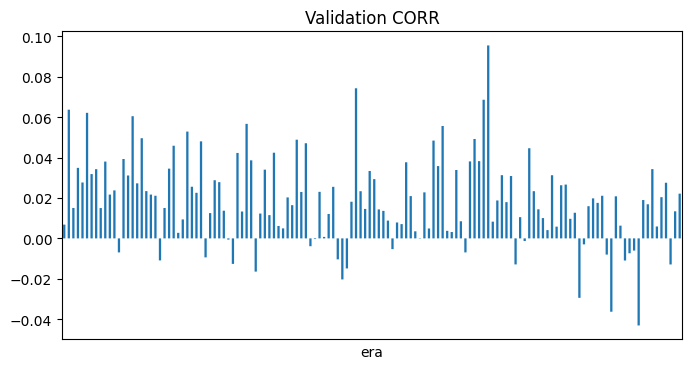

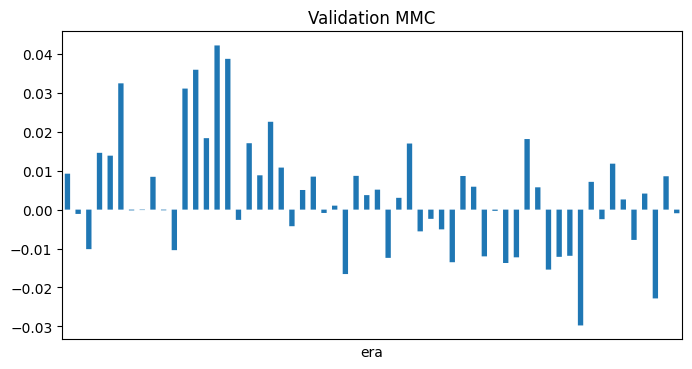

In [35]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

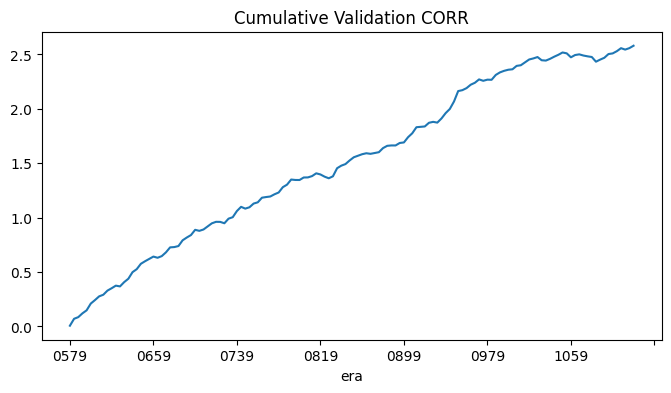

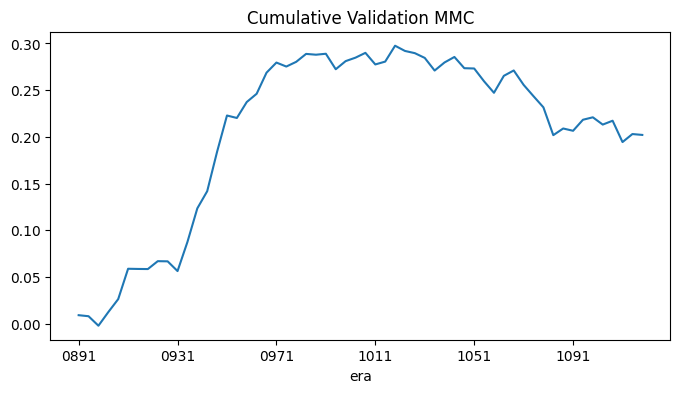

In [36]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

In [37]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.01897 dtype: float64,prediction 0.003485 dtype: float64
std,prediction 0.021832 dtype: float64,prediction 0.014662 dtype: float64
sharpe,prediction 0.868913 dtype: float64,prediction 0.237722 dtype: float64
max_drawdown,prediction 0.084658 dtype: float64,prediction 0.103105 dtype: float64


These performance metrics above are not amazing but that's ok, we are just getting started. In the next few tutorials, you will learn how to improve our model performance.

In [33]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
a = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
a.to_csv(f"predictions2/july24_2.csv")

2024-07-24 18:12:49,599 INFO numerapi.utils: target file already exists
2024-07-24 18:12:49,601 INFO numerapi.utils: download complete
